In [1]:
import numpy as np
import os
dtype = np.float32

import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
import os

from transformers import CLIPVisionModelWithProjection, AutoModelForCausalLM
from transformers import AutoModel, AutoTokenizer, OPTForCausalLM, BloomForCausalLM
import numpy

from huggingface_hub import try_to_load_from_cache, _CACHED_NO_EXIST
from huggingface_hub import scan_cache_dir

import glob
import random
import json
import os

device = torch.device("cuda:2")

def get_named_linears(module):
    return {name: m for name, m in module.named_modules() if isinstance(m, nn.Linear)}

def get_blocks(model):
    if model.__class__.__name__ in ("LlamaForCausalLM", "Qwen2ForCausalLM"):
        layers = model.model.layers
    elif model.__class__.__name__ == "LlavaLlamaForCausalLM":
        layers = model.model.layers
    elif isinstance(model, OPTForCausalLM):
        layers = model.model.decoder.layers
    elif isinstance(model, BloomForCausalLM):
        layers = model.transformer.h
    elif "mpt" in str(model.__class__).lower():
        layers = model.transformer.blocks
    elif "falcon" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "bigcode" in str(model.__class__).lower():
        layers = model.transformer.h
    elif "neox" in str(model.__class__).lower():
        layers = model.gpt_neox.layers
    elif model.__class__.__name__ == "LlavaLlamaModel":
        layers = model.llm.model.layers
    elif model.__class__.__name__ in ("CLIPModel"):
        vision_layers = model.vision_model.encoder.layers
        text_layers = model.text_model.encoder.layers
        layers = {'vision': vision_layers,
                  'text': text_layers}
    else:
        raise NotImplementedError(type(model))
    # if not isinstance(layers, dict):
    #     layers = {'': layers}
    return layers

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Weight 하나씩 distribution plot하기

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# This setting ensures that minus signs are displayed correctly in plots.
plt.rcParams['axes.unicode_minus'] = False

def plot_tensor_distributions(tensor_2d: torch.Tensor, name, save_path):
    if tensor_2d.dim() != 2:
        raise ValueError("Input tensor must be 2-dimensional.")

    print(name, f"shape: {tensor_2d.shape}")
    # print(f"Tensor device: {tensor_2d.device}")

    # 1. Calculate row-wise statistics (dim=1)
    row_means = torch.mean(tensor_2d, dim=1)
    row_stds = torch.std(tensor_2d, dim=1)
    row_norms = torch.linalg.norm(tensor_2d, dim=1)  # Default is L2 Norm

    # 2. Calculate column-wise statistics (dim=0)
    col_means = torch.mean(tensor_2d, dim=0)
    col_stds = torch.std(tensor_2d, dim=0)
    col_norms = torch.linalg.norm(tensor_2d, dim=0)  # Default is L2 Norm

    # 3. Visualize the distributions
    # Matplotlib/Seaborn expects NumPy arrays, so we convert tensors via .cpu().numpy()
    fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex='col')
    fig.suptitle(name, fontsize=20, y=1.02)

    # Plot row-wise statistical distributions
    sns.histplot(row_means.cpu().numpy(), kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Row Mean Distribution', fontsize=14)
    axes[0, 0].set_xlabel('Mean Value')
    axes[0, 0].set_ylabel('Frequency')

    sns.histplot(row_stds.cpu().numpy(), kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Row Standard Deviation Distribution', fontsize=14)
    axes[0, 1].set_xlabel('Standard Deviation Value')

    sns.histplot(row_norms.cpu().numpy(), kde=True, ax=axes[0, 2])
    axes[0, 2].set_title('Row Norm (L2) Distribution', fontsize=14)
    axes[0, 2].set_xlabel('Norm Value')

    # Plot column-wise statistical distributions
    sns.histplot(col_means.cpu().numpy(), kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Column Mean Distribution', fontsize=14)
    axes[1, 0].set_xlabel('Mean Value')
    axes[1, 0].set_ylabel('Frequency')

    sns.histplot(col_stds.cpu().numpy(), kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Column Standard Deviation Distribution', fontsize=14)
    axes[1, 1].set_xlabel('Standard Deviation Value')

    sns.histplot(col_norms.cpu().numpy(), kde=True, ax=axes[1, 2])
    axes[1, 2].set_title('Column Norm (L2) Distribution', fontsize=14)
    axes[1, 2].set_xlabel('Norm Value')

    # Adjust layout for a clean plot.
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    plt.close(fig)
    # plt.show()


def plot_normalized_distributions(tensor_2d: torch.Tensor, name, save_path):
    """
    Normalizes a 2D tensor in four different ways based on standard deviation,
    assuming the mean is 0, and visualizes the distribution of its elements.

    Args:
        tensor_2d (torch.Tensor): The 2D PyTorch tensor to analyze.
    """
    if tensor_2d.dim() != 2:
        raise ValueError("Input tensor must be 2-dimensional.")

    # Epsilon for numerical stability to avoid division by zero.
    epsilon = 1e-8 # 0으로 설정 시 std가 0인 행/열이 있으면 NaN/inf 발생 가능
    # epsilon = 0 # As requested by the user. Kept 1e-8 for stability.

    # --- 1. Normalize by Global Standard Deviation ---
    global_std = torch.std(tensor_2d)
    tensor_norm_global = tensor_2d / (global_std + epsilon)

    # --- 2. Normalize by Row-wise Standard Deviation ---
    # keepdim=True avoids the need to manually unsqueeze dimensions for broadcasting.
    row_stds = torch.std(tensor_2d, dim=1, keepdim=True)
    tensor_norm_row = tensor_2d / (row_stds + epsilon)

    # --- 3. Normalize by Column-wise Standard Deviation ---
    col_stds = torch.std(tensor_2d, dim=0, keepdim=True)
    tensor_norm_col = tensor_2d / (col_stds + epsilon)

    # --- 4. Normalize by Row-wise then Column-wise Standard Deviation ---
    # First, normalize by row std (already calculated as tensor_norm_row)
    # Then, normalize the result by column std
    col_stds_of_row_normed = torch.std(tensor_norm_row, dim=0, keepdim=True)
    tensor_norm_row_col = tensor_norm_row / (col_stds_of_row_normed + epsilon)

    # --- 5. Visualize Distributions ---
    # 레이아웃을 1x4로 변경하고 figsize를 조정합니다.
    fig, axes = plt.subplots(1, 4, figsize=(24, 5))
    fig.suptitle(name, fontsize=15, y=1.0)

    # Flatten each tensor to 1D to plot its element distribution.
    sns.histplot(tensor_norm_global.flatten().cpu().numpy(), kde=True, ax=axes[0])
    axes[0].set_title('1. Normalized by Global Std Dev', fontsize=14)
    axes[0].set_xlabel('Normalized Value')
    axes[0].set_ylabel('Frequency')

    sns.histplot(tensor_norm_row.flatten().cpu().numpy(), kde=True, ax=axes[1])
    axes[1].set_title('2. Normalized by Row-wise Std Dev', fontsize=14)
    axes[1].set_xlabel('Normalized Value')

    sns.histplot(tensor_norm_col.flatten().cpu().numpy(), kde=True, ax=axes[2])
    axes[2].set_title('3. Normalized by Column-wise Std Dev', fontsize=14)
    axes[2].set_xlabel('Normalized Value')
    
    sns.histplot(tensor_norm_row_col.flatten().cpu().numpy(), kde=True, ax=axes[3])
    axes[3].set_title('4. Row then Column Normalization', fontsize=14)
    axes[3].set_xlabel('Normalized Value')
    # ***** 추가된 부분 끝 *****

    print(name, f"shape: {tensor_2d.shape}")
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    plt.close(fig) # 그래프 창이 뜨지 않도록 닫아줍니다.
    # plt.show()


model_name:  meta-llama--Meta-Llama-3-8B


Loading checkpoint shards: 100%|██████████| 7/7 [00:00<00:00,  7.17it/s]


meta-llama--Meta-Llama-3-8B Layer 0 / q_proj shape: torch.Size([4096, 4096])


KeyboardInterrupt: 

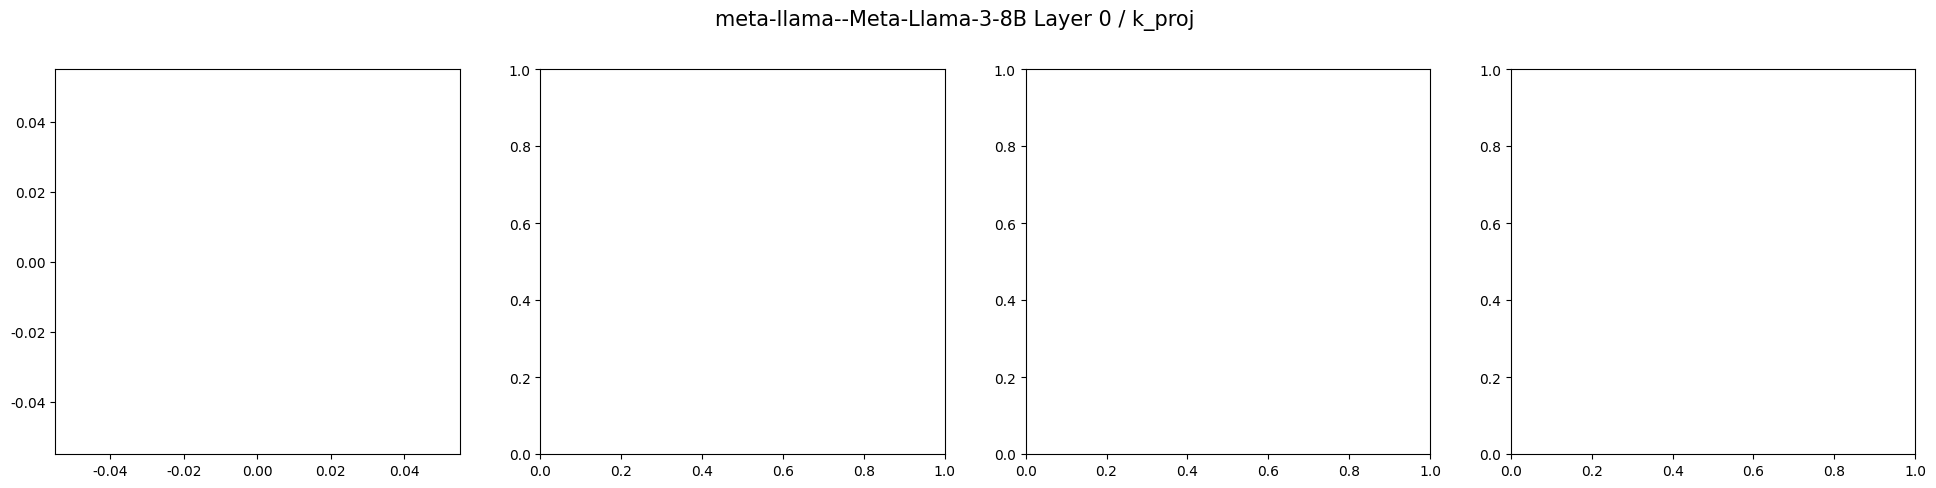

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from transformers import AutoModelForCausalLM
import os

model_list = [
    # 'meta-llama--Llama-2-7b-hf',
    'meta-llama/Meta-Llama-3-8B',
]
block_size = 16

for model_name in model_list:
    model_name = model_name.replace('/', '--')
    print('model_name: ', model_name)
    model_path = f"./hf_model/{model_name}"
    model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)
    layers = get_blocks(model)

    for idx in [0, 1, 10, 31]:
        named_linears = get_named_linears(layers[idx])

        for n, m in named_linears.items():
            W = m.weight.data.detach().cpu()
            # plot_tensor_distributions(W, f'{model_name} Layer {idx} / {n.split(".")[-1]}', f"./plot/vector_dist/{model_name}/{n.split('.')[-1]}/{idx}_{n.split('.')[-1]}.png")            
            plot_normalized_distributions(W, f'{model_name} Layer {idx} / {n.split(".")[-1]}', f"./plot/element_dist_normed_weights/{model_name}/{n.split('.')[-1]}/{idx}_{n.split('.')[-1]}.png")            

# 한 layer의 여러 weight distribution plot하기

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM
import os
from typing import Dict, List, Tuple

def plot_multiple_weight_distributions(weights_dict: Dict[str, torch.Tensor], title: str, save_path: str):
    """
    여러 가중치 텐서들을 받아서, 4가지 정규화 방식에 대한 분포를 비교하여 하나의 그림에 플롯합니다.

    Args:
        weights_dict (Dict[str, torch.Tensor]): {'가중치 이름': 텐서} 형태의 딕셔너리
        title (str): 그래프의 전체 제목
        save_path (str): 그래프를 저장할 경로
    """
    num_weights = len(weights_dict)
    if num_weights == 0:
        print("No weights to plot.")
        return

    # 1x4 레이아웃으로 서브플롯 생성
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    fig.suptitle(title, fontsize=16, y=1.0)
    
    epsilon = 1e-8
    
    # 딕셔너리의 각 가중치 텐서에 대해 루프 실행
    for name, tensor_2d in weights_dict.items():
        if tensor_2d.dim() != 2:
            print(f"Skipping {name} as it is not a 2D tensor (shape: {tensor_2d.shape})")
            continue

        # --- 4가지 방식의 정규화 수행 ---
        tensor_norm_global = tensor_2d / (torch.std(tensor_2d) + epsilon)
        tensor_norm_row = tensor_2d / (torch.std(tensor_2d, dim=1, keepdim=True) + epsilon)
        tensor_norm_col = tensor_2d / (torch.std(tensor_2d, dim=0, keepdim=True) + epsilon)
        
        col_stds_of_row_normed = torch.std(tensor_norm_row, dim=0, keepdim=True)
        tensor_norm_row_col = tensor_norm_row / (col_stds_of_row_normed + epsilon)

        # --- 각 정규화 방식에 해당하는 축에 분포를 중첩해서 플롯 ---
        # label=name을 통해 범례에 표시될 이름을 지정합니다.
        sns.kdeplot(tensor_norm_global.flatten().cpu().numpy(), ax=axes[0], label=name, fill=True, alpha=0.1)
        sns.kdeplot(tensor_norm_row.flatten().cpu().numpy(), ax=axes[1], label=name, fill=True, alpha=0.1)
        sns.kdeplot(tensor_norm_col.flatten().cpu().numpy(), ax=axes[2], label=name, fill=True, alpha=0.1)
        sns.kdeplot(tensor_norm_row_col.flatten().cpu().numpy(), ax=axes[3], label=name, fill=True, alpha=0.1)

    # 각 서브플롯의 제목과 레이블 설정
    axes[0].set_title('1. Normalized by Global Std Dev', fontsize=12)
    axes[1].set_title('2. Normalized by Row-wise Std Dev', fontsize=12)
    axes[2].set_title('3. Normalized by Column-wise Std Dev', fontsize=12)
    axes[3].set_title('4. Row then Column Normalization', fontsize=12)
    
    for ax in axes:
        ax.set_xlabel('Normalized Value')
        ax.set_ylabel('Density')
        ax.legend() # 각 축에 범례 추가
        ax.grid(True, linestyle='--', alpha=0.6)

    # 레이아웃 조정 및 저장
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    plt.close(fig)
    print(f"Comparison plot saved to: {save_path}")

In [ ]:
model_list = [
    'meta-llama/Meta-Llama-3-8B',
]

for model_name in model_list:
    model_name_fs = model_name.replace('/', '--') # 파일 시스템 친화적인 이름
    print('model_name: ', model_name_fs)
    model_path = f"./hf_model/{model_name_fs}"
    
    # 모델 로딩 (경로가 없으면 다운로드)
    try:
        model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True, device_map='auto')
    except Exception:
        print(f"Local model not found. Downloading {model_name}...")
        model = AutoModelForCausalLM.from_pretrained(model_name, device_map='cpu')
        model.save_pretrained(model_path)

    layers = get_blocks(model)

    # 분석할 레이어 인덱스
    for idx in [0, 1, 15, 31]:
        print(f"--- Processing Layer {idx} ---")
        
        # 1. 한 레이어 내의 모든 가중치를 딕셔너리에 수집
        weights_to_compare = {}
        named_linears = get_named_linears(layers[idx])

        for n, m in named_linears.items():
            # key를 'q_proj' 와 같이 짧은 이름으로 사용
            weights_to_compare[n] = m.weight.data.detach().clone()

        # 2. 수집된 가중치들을 새로운 플롯 함수에 한 번에 전달
        if weights_to_compare:
            plot_multiple_weight_distributions(
                weights_dict=weights_to_compare,
                title=f'{model_name_fs} Layer {idx} - Weight Distribution Comparison',
                save_path=f"./plot/comparison/{model_name_fs}/layer_{idx}_comparison.png"
            )


model_name:  meta-llama--Meta-Llama-3-8B


Loading checkpoint shards: 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


--- Processing Layer 0 ---
